In [1]:
print ("hello world")

hello world


In [2]:
# %load ../train_and_append_boosted.py
import statistics
import collections
import getopt, sys
import matplotlib.pyplot as plt
import numpy as np
from numpy import linspace
import pandas
import math
from sklearn.preprocessing import StandardScaler
import root_numpy
from ROOT import gSystem
from root_numpy import root2array, array2tree
import time
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import plot_model
from math import sqrt
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import ROOT
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle


Welcome to JupyROOT 6.14/04


Using TensorFlow backend.


In [3]:
class MyDict(collections.OrderedDict):
    def __missing__(self, key):
        val = self[key] = MyDict()
        return val


In [4]:
# This converts a flat ntuple into a numpy array file, which is the input
# format used by keras in our setup. Creates one .npz file per analysis in the
# directory where you run it.

# Location of the lists of ntuples you want to convert to numpy format.
# I've assumed that the file lists are named following my convention.
# e.g. "signalFiles_resolved.txt"
fileListLocation = "../datasets_to_train/"
appendListLocation = "../datasets_to_append/"

# Name of the tree we want to use
inTreeName = "preselection"

# Prefix for the name of the output .npz files
outputPrefix = "trainingData_all_jets_"
#outputPrefix = "validationData_"

#for analysis in ["resolved", "intermediate", "boosted"]:
for analysis in ["intermediate"]:
    inFile_sig   = fileListLocation + "/signalFiles_" + analysis + ".txt"
    inFile_4b    = fileListLocation + "/4bFiles_" + analysis + ".txt"
    inFile_2b2j  = fileListLocation + "/2b2jFiles_" + analysis + ".txt"
    inFile_ttbar = fileListLocation + "/ttbarFiles_" + analysis + ".txt"
    appendFile_sig   = appendListLocation + "/signalFiles_" + analysis + ".txt"
    appendFile_4b    = appendListLocation + "/4bFiles_" + analysis + ".txt"
    appendFile_2b2j  = appendListLocation + "/2b2jFiles_" + analysis + ".txt"
    appendFile_ttbar = appendListLocation + "/ttbarFiles_" + analysis + ".txt"

    branchList = ["pT_hh",
                  "nMuon", "nElec",
                  "h1_M", "h1_Pt", "h1_Eta", "h1_Phi", "h1_j1_j2_dR",
                  "h2_M", "h2_Pt", "h2_Eta", "h2_Phi", "h2_j1_j2_dR",
                  "met_Et", "met_Phi", 
                  "h1_j1_BTag","h1_j2_BTag","h2_j1_BTag","h2_j2_BTag",
                  "mc_sf"]
    nFeatures = len(branchList)-1

    filepaths_sig   = []
    filepaths_4b    = []
    filepaths_2b2j  = []
    filepaths_ttbar = []

    f = open(inFile_sig,"r")
    for line in f:
        filepaths_sig.append(line.rstrip())
    f.close()

    f = open(inFile_4b,"r")
    for line in f:
        filepaths_4b.append(line.rstrip())
    f.close()

    f = open(inFile_2b2j,"r")
    for line in f:
        filepaths_2b2j.append(line.rstrip())
    f.close()

    f = open(inFile_ttbar,"r")
    for line in f:
        filepaths_ttbar.append(line.rstrip())
    f.close()

    appendPaths_sig   = []
    appendPaths_4b    = []
    appendPaths_2b2j  = []
    appendPaths_ttbar = []

    f = open(appendFile_sig,"r")
    for line in f:
        appendPaths_sig.append(line.rstrip())
    f.close()

    f = open(appendFile_4b,"r")
    for line in f:
        appendPaths_4b.append(line.rstrip())
    f.close()

    f = open(appendFile_2b2j,"r")
    for line in f:
        appendPaths_2b2j.append(line.rstrip())
    f.close()

    f = open(appendFile_ttbar,"r")
    for line in f:
        appendPaths_ttbar.append(line.rstrip())
    f.close()

    dat_sig   = root2array(filepaths_sig,   branches=branchList, treename=inTreeName)
    dat_4b    = root2array(filepaths_4b,    branches=branchList, treename=inTreeName)
    dat_2b2j  = root2array(filepaths_2b2j,  branches=branchList, treename=inTreeName)
    dat_ttbar = root2array(filepaths_ttbar, branches=branchList, treename=inTreeName)
    datAppend_sig   = root2array(appendPaths_sig,   branches=branchList, treename=inTreeName)
    datAppend_4b    = root2array(appendPaths_4b,    branches=branchList, treename=inTreeName)
    datAppend_2b2j  = root2array(appendPaths_2b2j,  branches=branchList, treename=inTreeName)
    datAppend_ttbar = root2array(appendPaths_ttbar, branches=branchList, treename=inTreeName)

    #np.savez(outputPrefix + analysis + ".npz", sig=dat_sig, bkg_4b=dat_4b, bkg_2b2j=dat_2b2j, bkg_ttbar=dat_ttbar)


In [5]:
    nFeatures = len(branchList)-1


In [6]:
# This program trains a neural network based on input numpy array files.
# Output is one trained NN file (nn_*.h5) and one scaler file (scaler_*.sav)
# per analysis. Optionally also makes plots of the output distributions for the
# training sample.

### NOTE this program uses 0.2 of the data as a validation set

In [7]:
# Path of the directory whit lits of ntuples to append score to
fileListLocation = "test_append.txt"
# Path of the directory containing .npz files to train on.
# Standard naming convention is assumed (e.g. "trainingData_resolved.npz")
trainingDataPath = "../train_all_jets/"

In [8]:
# Training parameters
numEpochs = 10
batchSize = 100
dropoutFraction = 0.3
# initial learning rate for adamax
init_lr = MyDict()
init_lr["boosted"] = 5e-5
init_lr["intermediate"] = 5e-3
init_lr["resolved"] = 5e-3

# store parameters of the network in a string
#param_string = "_w_OPadamaxEP"+str(numEpochs)+"BS"+str(batchSize)+"DO"+str(dropoutFraction).replace(".","")
# Plot score distributions for the training sample?
makePlots = False

target_nevents = 100000

signal_weight = MyDict()
ttbar_weight = MyDict()
qcd_weight = MyDict()
analysis = "intermediate"
param_string = "testSave_all_jets_LR"+str(init_lr[analysis]).replace("0.","0p")
print ("paramters string "+param_string)

paramters string testSave_all_jets_LR0p005


In [9]:
# Load the input file and grab the data from it.
# Label each type of background
# Calculate weight for each 'target' sample
#inFile = np.load(trainingDataPath + "/trainingData_all_jets_" + analysis + ".npz")

signalData = pandas.DataFrame(dat_sig)
#signalData = pandas.DataFrame(inFile["sig"])
signalData["target"] = 0
#signal_weight[analysis] = target_nevents/len(signalData)
print(len(signalData),"(",signal_weight[analysis],") signal (weight) events found")
n_sig = len(signalData)

signalAppendData = pandas.DataFrame(datAppend_sig)
signalAppendData["target"] = 0
print(len(signalAppendData),"(",signal_weight[analysis],") signal (weight) events found")
n_sig = len(signalAppendData)
signal_weight[analysis] = target_nevents/(len(signalData)+len(signalAppendData))
signalData = signalData.append(signalAppendData)


17920 ( MyDict() ) signal (weight) events found
24304 ( MyDict() ) signal (weight) events found


In [10]:
backgroundData = pandas.DataFrame(dat_4b)
backgroundData["target"] = 1

backgroundAppend_4bData = pandas.DataFrame(datAppend_4b)
backgroundAppend_4bData["target"] = 1
backgroundData = backgroundData.append(backgroundAppend_4bData)
print(len(backgroundData), "4b background events found")

backgroundAppend_2b2j = pandas.DataFrame(datAppend_2b2j)
backgroundAppend_2b2j["target"] = 1
backgroundData = backgroundData.append(backgroundAppend_2b2j)

background_2b2j = pandas.DataFrame(dat_2b2j)
background_2b2j["target"] = 1
backgroundData = backgroundData.append(background_2b2j)
print(len(background_2b2j)+len(backgroundAppend_2b2j), "2b2j background events found")

n_qcd_bkg = len(backgroundData)+len(backgroundAppend_4bData)+len(background_2b2j)+len(backgroundAppend_2b2j)
qcd_weight[analysis] = target_nevents/n_qcd_bkg
print(n_qcd_bkg,"(",qcd_weight[analysis], ") qcd (weight) background events found")

691238 4b background events found
688240 2b2j background events found
2408524 ( 0.04151920429275357 ) qcd (weight) background events found


In [11]:
background_ttbar = pandas.DataFrame(dat_ttbar)
#background_ttbar = pandas.DataFrame(inFile["bkg_ttbar"])
background_ttbar["target"] = 2
ttbar_weight[analysis] = target_nevents/len(background_ttbar)
print(len(background_ttbar),"(",ttbar_weight[analysis], ") ttbar (weight) background events found")
backgroundData = backgroundData.append(background_ttbar)
n_ttbar = len(background_ttbar)

backgroundAppend_ttbar = pandas.DataFrame(datAppend_ttbar)
backgroundAppend_ttbar["target"] = 2
n_ttbar = len(background_ttbar)+len(backgroundAppend_ttbar)
ttbar_weight[analysis] = target_nevents/n_ttbar
print(n_ttbar,"(",ttbar_weight[analysis], ") ttbar (weight) background events found")
backgroundData = backgroundData.append(backgroundAppend_ttbar)


39224 ( 2.5494595145829084 ) ttbar (weight) background events found
80232 ( 1.2463854821019045 ) ttbar (weight) background events found


In [12]:
allData = signalData.append(backgroundData, ignore_index = True)

# Set all event weights to 1 by default
allData.loc[:, 'mc_sf'] = 1.
# Apply manual event weighting: numbers that give "reasonable behavior"
allData.loc[allData.target == 0, 'mc_sf'] = signal_weight[analysis] # signal
allData.loc[allData.target == 1, 'mc_sf'] = qcd_weight[analysis]    # QCD
allData.loc[allData.target == 2, 'mc_sf'] = ttbar_weight[analysis]  # ttbar

allData = shuffle(allData)

In [13]:
xTrainData = allData
procType = xTrainData.pop("target")


X_train, X_run, yTypeTrain, yTypeRun = train_test_split(xTrainData, procType, test_size=0.4, random_state=1)
X_train, X_test, yTypeTrain, yTypeTest = train_test_split(X_train, yTypeTrain, test_size=0.2, random_state=1)

# These aren't input features, separate them out.
evtWeightsTrain = X_train.pop("mc_sf")
evtWeightsVal = X_test.pop("mc_sf")
evtWeightsRun = X_run.pop("mc_sf")

In [14]:
X_train.head()

,pT_hh,nMuon,nElec,h1_M,h1_Pt,h1_Eta,h1_Phi,h1_j1_j2_dR,h2_M,h2_Pt,h2_Eta,h2_Phi,h2_j1_j2_dR,met_Et,met_Phi,h1_j1_BTag,h1_j2_BTag,h2_j1_BTag,h2_j2_BTag
753830,226.192905,0,0,79.044403,262.198242,-1.061708,0.677039,0.277459,163.519177,116.027637,-0.954333,-1.429256,1.916590,29.079323,2.895470,0,0,0,0
83009,286.958843,0,0,152.382645,405.686218,-0.710999,-1.696129,0.660055,199.076009,121.650954,1.776378,1.261287,2.319798,32.497677,0.377227,1,0,0,0
28385,59.082756,0,0,73.032501,257.435608,1.194992,-0.680670,1.025881,66.656538,208.498844,0.917343,2.317907,0.587316,32.423096,2.157021,1,0,1,0
270592,34.071897,0,0,95.741875,295.731232,-1.263368,-3.045896,0.624137,138.813998,273.778845,2.380451,0.187304,1.298992,14.253534,-2.432236,0,0,1,0
1375648,478.562787,0,0,65.050186,703.645325,0.741074,-3.086202,0.269190,73.324029,228.324243,-0.786490,-0.083454,0.627937,32.891399,3.092369,0,1,1,1


In [15]:
# Convert pandas dataframes into numpy arrays
X_test = X_test.values
X_train = X_train.values
X_run = X_run.values
evtWeightsTrain = evtWeightsTrain.values
evtWeightsVal = evtWeightsVal.values
evtWeightsRun = evtWeightsRun.values
y_test = keras.utils.to_categorical(yTypeTest, num_classes=3)
y_train = keras.utils.to_categorical(yTypeTrain, num_classes=3)
yTypeTest = yTypeTest.values
yTypeTrain = yTypeTrain.values
yTypeRun = yTypeRun.values

In [16]:
print(np.unique(yTypeTrain,return_counts=True))
print(np.unique(yTypeTest,return_counts=True))
print(np.unique(yTypeRun,return_counts=True))

(array([0, 1, 2]), array([ 20334, 662126,  38468]))
(array([0, 1, 2]), array([  5120, 165444,   9668]))
(array([0, 1, 2]), array([ 16770, 551908,  32096]))


In [17]:
# Convert this into the right format for keras

# Scale input features to mean=0, stddev=1
classStd1 = StandardScaler().fit(X_train)
X_train = classStd1.transform(X_train)
X_test = classStd1.transform(X_test)
# scale run later
#X_run = classStd1.fit_transform(X_run)
joblib.dump(classStd1, "scaler_testingAppend.sav")

['scaler_testingAppend.sav']

In [18]:
# Set all event weights to 1 by default
signalData.loc[:, 'mc_sf'] = 1.
# Apply manual event weighting: numbers that give "reasonable behavior"
signalData.loc[signalData.target == 0, 'mc_sf'] = signal_weight[analysis] # signal

sig_only_target = signalData.pop("target")
sig_only_mc_sf = signalData.pop("mc_sf")

sig_only_mc_sf = sig_only_mc_sf.values
sig_only_target = sig_only_target.values

allXdata = signalData.values
og_mean = statistics.mean(allXdata[:,0])
print(og_mean)

162.49969480178154


In [19]:
allXdata_scaled = classStd1.transform(allXdata)
scaled_mean = statistics.mean(allXdata_scaled[:,0])
print("mean", og_mean)
print("scaled mean", scaled_mean)


mean 162.49969480178154
scaled mean -0.2104018942704421


In [20]:
np.shape(X_train)

(720928, 19)

In [21]:
# Construct the NN architecture
model = Sequential()
model.add(Dense(200, activation="relu", input_dim= nFeatures))#input_dim should be as long as the branchList given to the NN
model.add(Dropout(dropoutFraction))
model.add(Dense(200, activation="relu"))
model.add(Dense(3, activation="softmax")) # output nodes

model.compile(
        loss='categorical_crossentropy',  # we train 10-way classification
        optimizer=keras.optimizers.adamax(lr=init_lr[analysis]),  # for SGD
        metrics=['acc']  # report accuracy during training
        )

In [22]:
# Train the NN
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=numEpochs, batch_size=batchSize, sample_weight=evtWeightsTrain,shuffle=True)
# no need to save model for now 
model.save("testingAppend.h5")

Train on 720928 samples, validate on 180232 samples
Epoch 1/10
720928/720928 [==============================] - 31s 43us/step - loss: 0.1319 - acc: 0.4600 - val_loss: 0.9979 - val_acc: 0.4999
Epoch 2/10
720928/720928 [==============================] - 31s 43us/step - loss: 0.1277 - acc: 0.4845 - val_loss: 1.0809 - val_acc: 0.4431
Epoch 3/10
720928/720928 [==============================] - 31s 44us/step - loss: 0.1261 - acc: 0.5004 - val_loss: 1.0391 - val_acc: 0.4764
Epoch 4/10
720928/720928 [==============================] - 32s 44us/step - loss: 0.1251 - acc: 0.5074 - val_loss: 1.0495 - val_acc: 0.4724
Epoch 5/10
720928/720928 [==============================] - 32s 45us/step - loss: 0.1244 - acc: 0.5115 - val_loss: 0.9895 - val_acc: 0.5396
Epoch 6/10
720928/720928 [==============================] - 31s 43us/step - loss: 0.1239 - acc: 0.5148 - val_loss: 1.0411 - val_acc: 0.4873
Epoch 7/10
720928/720928 [==============================] - 31s 43us/step - loss: 0.1236 - acc: 0.5159 - val

2019-08-02 14:48:15.190077: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX


In [23]:
# Run training sample back through the NN
probTrain = model.predict(X_train)
probTest = model.predict(X_test)

In [81]:
history.history['val_acc'][-1]

0.5340623748506651

In [ ]:
y_test

In [30]:
probTest

array([[0.17439821, 0.12288999, 0.7027118 ],
       [0.27300426, 0.14304492, 0.58395076],
       [0.1744123 , 0.81113654, 0.01445119],
       ...,
       [0.5547601 , 0.32765952, 0.11758044],
       [0.2919829 , 0.22619435, 0.4818228 ],
       [0.2904513 , 0.6864319 , 0.0231169 ]], dtype=float32)

In [34]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
for i in range(0,3):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], probTest[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

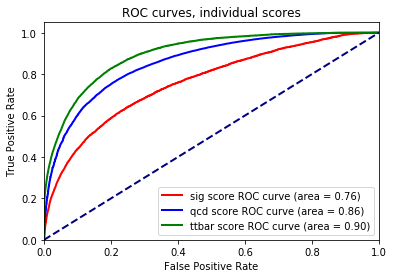

In [35]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='red',
         lw=lw, label='sig score ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='blue',
         lw=lw, label='qcd score ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='green',
         lw=lw, label='ttbar score ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves, individual scores')
plt.legend(loc="lower right")
plt.show()

In [75]:
thresholds[0][2000]

0.8031291

In [78]:
tpr[0][2000]

0.24921875

In [77]:
fpr[0][2000]

0.03223080085887889

In [79]:
np.shape(tpr[0])

(10703,)

In [80]:
np.shape(fpr[0])

(10703,)

In [63]:
np.shape(thresholds[0])

(10703,)

In [81]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probTest.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

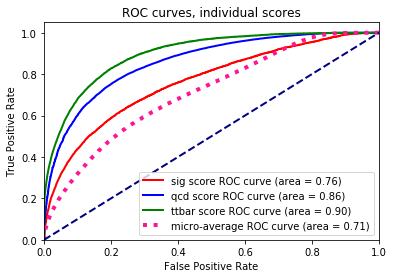

In [82]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='red',
         lw=lw, label='sig score ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='blue',
         lw=lw, label='qcd score ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='green',
         lw=lw, label='ttbar score ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves, individual scores')
plt.legend(loc="lower right")
plt.show()

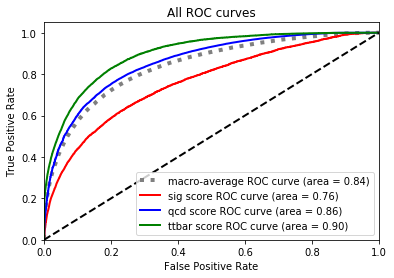

In [83]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(0,3)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(0,3):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 3

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
#plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='gray', linestyle=':', linewidth=4)

colors = cycle(['red', 'blue', 'green'])
types = cycle(['sig', 'qcd', 'ttbar'])
for i, color, typ in zip(range(0,3), colors, types):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} score ROC curve (area = {1:0.2f})'.format(typ, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All ROC curves')
plt.legend(loc="lower right")
plt.show()


In [84]:
np.unique(np.concatenate([fpr[i] for i in range(0,3)]), True)

(array([0.00000000e+00, 5.86290190e-06, 1.17258038e-05, ...,
        9.93170138e-01, 9.93981607e-01, 1.00000000e+00]),
 array([    0, 32435, 32440, ..., 32416, 32418, 10702]))

In [139]:
# Construct discriminant
scores_train = np.log(probTrain[:,0]/(probTrain[:,1] + probTrain[:,2]))
scores_test = np.log(probTest[:,0]/(probTest[:,1] + probTest[:,2]))

# Format data for convenience
trainData = pandas.DataFrame(X_train)
trainData['sig_score'] = pandas.Series(probTrain[:,0], index=trainData.index)
trainData['qcd_score'] = pandas.Series(probTrain[:,1], index=trainData.index)
trainData['top_score'] = pandas.Series(probTrain[:,2], index=trainData.index)
trainData['disc'] = pandas.Series(scores_train, index=trainData.index)
trainData['weight'] = pandas.Series(evtWeightsTrain, index=trainData.index)
trainData['process'] = pandas.Series(yTypeTrain, index=trainData.index)

print("signal mean = ", statistics.mean(trainData[trainData.process == 0]['sig_score']))
print("   QCD mean = ", statistics.mean(trainData[trainData.process == 1]['sig_score']))
print(" ttbar mean = ", statistics.mean(trainData[trainData.process == 2]['sig_score']))

signal mean =  0.5867256117914408
   QCD mean =  0.3556838546319745
 ttbar mean =  0.23298553464538205


In [140]:
testData = pandas.DataFrame(X_test)
testData['sig_score'] = pandas.Series(probTest[:,0], index=testData.index)
testData['qcd_score'] = pandas.Series(probTest[:,1], index=testData.index)
testData['top_score'] = pandas.Series(probTest[:,2], index=testData.index)
testData['disc'] = pandas.Series(scores_test, index=testData.index)
testData['weight'] = pandas.Series(evtWeightsVal, index=testData.index)
testData['process'] = pandas.Series(yTypeTest, index=testData.index)

Text(0,0.5,'1/N dN/d(NN Score)')

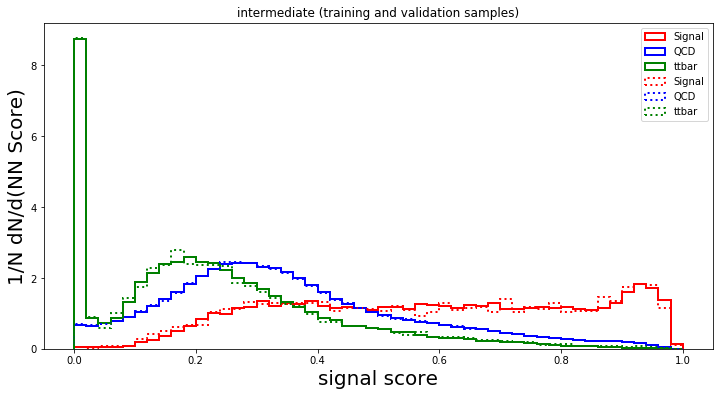

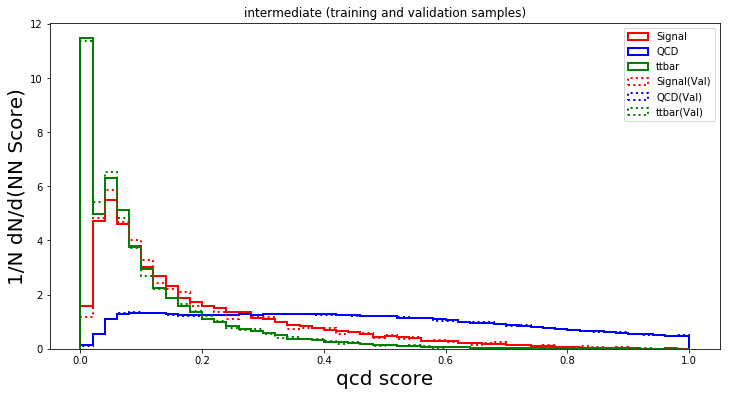

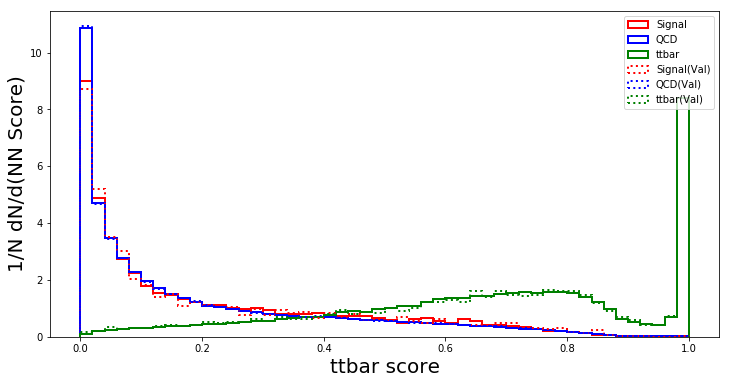

In [141]:
# Plot distributions of signal score on validation data
hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(trainData[trainData.process == 0]['sig_score'], color=["r"], weights=trainData[trainData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(trainData[trainData.process == 1]['sig_score'], color=["b"], weights=trainData[trainData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(trainData[trainData.process == 2]['sig_score'], color=["g"], weights=trainData[trainData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.hist(testData[testData.process == 0]['sig_score'], color=["r"], linestyle = "dotted", weights=testData[testData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(testData[testData.process == 1]['sig_score'], color=["b"], linestyle = "dotted", weights=testData[testData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(testData[testData.process == 2]['sig_score'], color=["g"], linestyle = "dotted", weights=testData[testData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)
#plt.yscale('log')
plt.title(analysis + " (training and validation samples)")
plt.figure(figsize=(12,6))
plt.hist(trainData[trainData.process == 0]['qcd_score'], color=["r"], weights=trainData[trainData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(trainData[trainData.process == 1]['qcd_score'], color=["b"], weights=trainData[trainData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(trainData[trainData.process == 2]['qcd_score'], color=["g"], weights=trainData[trainData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.hist(testData[testData.process == 0]['qcd_score'], color=["r"], linestyle = "dotted", weights=testData[testData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal(Val)', **hist_params)
plt.hist(testData[testData.process == 1]['qcd_score'], color=["b"], linestyle = "dotted", weights=testData[testData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD(Val)', **hist_params)
plt.hist(testData[testData.process == 2]['qcd_score'], color=["g"], linestyle = "dotted", weights=testData[testData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar(Val)', **hist_params)
plt.legend(loc='best')
plt.xlabel("qcd score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)
plt.title(analysis + " (training and validation samples)")
plt.figure(figsize=(12,6))
plt.hist(trainData[trainData.process == 0]['top_score'], color=["r"], weights=trainData[trainData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(trainData[trainData.process == 1]['top_score'], color=["b"], weights=trainData[trainData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(trainData[trainData.process == 2]['top_score'], color=["g"], weights=trainData[trainData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.hist(testData[testData.process == 0]['top_score'], color=["r"], linestyle = "dotted", weights=testData[testData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal(Val)', **hist_params)
plt.hist(testData[testData.process == 1]['top_score'], color=["b"], linestyle = "dotted", weights=testData[testData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD(Val)', **hist_params)
plt.hist(testData[testData.process == 2]['top_score'], color=["g"], linestyle = "dotted", weights=testData[testData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar(Val)', **hist_params)
plt.legend(loc='best')
plt.xlabel("ttbar score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)

Text(0,0.5,'1/N dN/d(NN Score)')

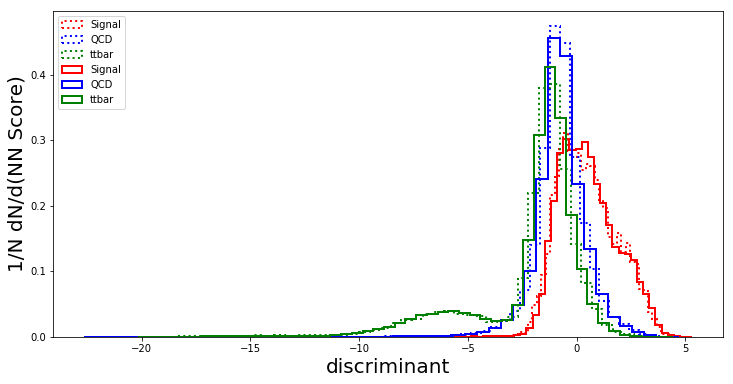

In [142]:
scores_test
plt.figure(figsize=(12,6))
plt.hist(testData[testData.process == 0]['disc'], color=["r"], linestyle = "dotted", weights=testData[testData.process == 0]['weight'], histtype='step', label='Signal', **hist_params)
plt.hist(testData[testData.process == 1]['disc'], color=["b"], linestyle = "dotted", weights=testData[testData.process == 1]['weight'], histtype='step', label='QCD', **hist_params)
plt.hist(testData[testData.process == 2]['disc'], color=["g"], linestyle = "dotted", weights=testData[testData.process == 2]['weight'], histtype='step', label='ttbar', **hist_params)
plt.hist(trainData[trainData.process == 0]['disc'], color=["r"], weights=trainData[trainData.process == 0]['weight'], histtype='step', label='Signal', **hist_params)
plt.hist(trainData[trainData.process == 1]['disc'], color=["b"], weights=trainData[trainData.process == 1]['weight'], histtype='step', label='QCD', **hist_params)
plt.hist(trainData[trainData.process == 2]['disc'], color=["g"], weights=trainData[trainData.process == 2]['weight'], histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("discriminant",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)


In [134]:
print(np.unique(yTypeRun,return_counts=True))

(array([0, 1, 2]), array([ 16770, 551908,  32096]))


In [29]:
##append_mc_sf = signalAppendData.pop("mc_sf")
#append_mc_sf = X_run.pop("mc_sf")
#append_mc_sf = append_mc_sf.values
## Convert pandas dataframes into numpy arrays
## signalAppendData = signalAppendData.values
#X_run = X_run.values

In [30]:
X_run_clone = X_run
X_run_forload = X_run
appendData_clone = pandas.DataFrame(X_run_clone)

X_run = classStd1.transform(X_run)


In [31]:
# Run training sample back through the NN
probAppend = model.predict(X_run)

In [32]:
# Format data for convenience
appendData = pandas.DataFrame(X_run)
appendData['sig_score'] = pandas.Series(probAppend[:,0], index=appendData.index)
appendData['qcd_score'] = pandas.Series(probAppend[:,1], index=appendData.index)
appendData['top_score'] = pandas.Series(probAppend[:,2], index=appendData.index)
appendData['weight'] = pandas.Series(evtWeightsRun, index=appendData.index)
appendData['process'] = pandas.Series(yTypeRun, index=appendData.index)


print("signal score mean = ", statistics.mean(appendData['sig_score']))
print("   QCD score mean = ", statistics.mean(appendData['qcd_score']))
print(" ttbar score mean = ", statistics.mean(appendData['top_score']))

signal score mean =  0.34408516245920584
   QCD score mean =  0.41132349289090286
 ttbar score mean =  0.24459134467492671


In [33]:
probAppend[:,2]
len(appendData[appendData.process == 2])
print(np.unique(yTypeRun,return_counts=True))

(array([0, 1, 2]), array([ 19313, 545322,  32797]))


Text(0,0.5,'1/N dN/d(NN Score)')

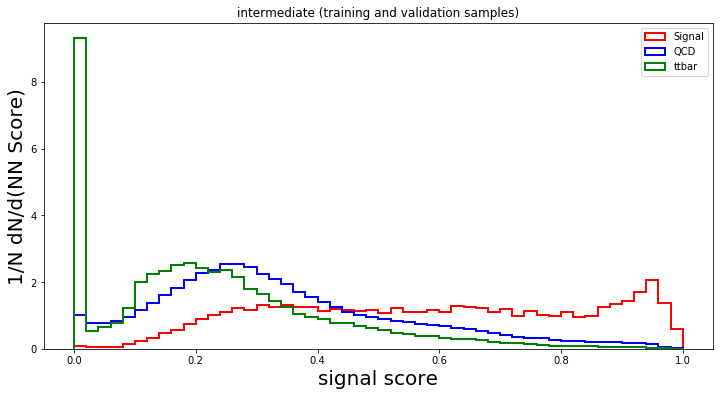

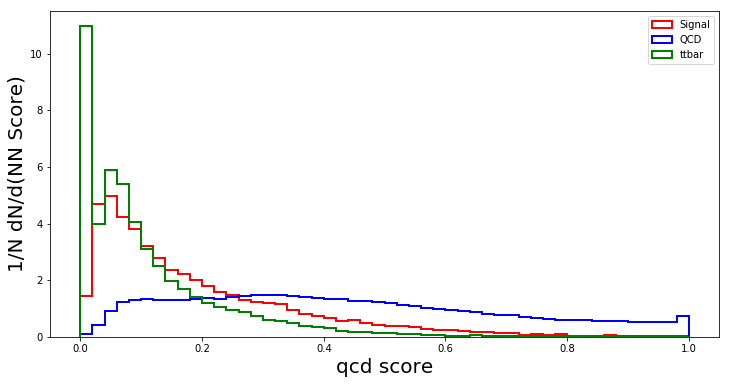

In [34]:
# Plot distributions of signal score on validation data
hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(appendData[appendData.process == 0]['sig_score'], color=["r"], weights=appendData[appendData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(appendData[appendData.process == 1]['sig_score'], color=["b"], weights=appendData[appendData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(appendData[appendData.process == 2]['sig_score'], color=["g"], weights=appendData[appendData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)
#plt.yscale('log')
plt.title(analysis + " (training and validation samples)")
plt.figure(figsize=(12,6))
plt.hist(appendData[appendData.process == 0]['qcd_score'], color=["r"], weights=appendData[appendData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(appendData[appendData.process == 1]['qcd_score'], color=["b"], weights=appendData[appendData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(appendData[appendData.process == 2]['qcd_score'], color=["g"], weights=appendData[appendData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("qcd score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)

Text(0,0.5,'leading higgs candidate mass')

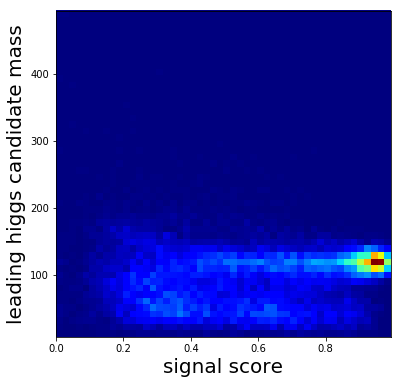

In [35]:
appendData_clone['process'] = pandas.Series(yTypeRun, index=appendData.index)
plt.figure(figsize=(6,6))
plt.hist2d(appendData[appendData.process == 0]['sig_score'],appendData_clone[appendData_clone.process == 0][3],bins=(50,50),cmap=plt.cm.jet)
plt.xlabel("signal score",fontsize=20)
plt.ylabel("leading higgs candidate mass",fontsize=20)

In [36]:
plt.savefig("nn_vs_h1M_signal.png")

<Figure size 432x288 with 0 Axes>

In [37]:
appendData_clone.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,process
0,186.631434,0.0,0.0,68.361534,253.323441,-0.524437,-2.601593,0.228536,73.704294,121.510046,1.568009,-0.232106,1.085954,40.007195,-1.604813,0.0,0.0,0.0,0.0,1
1,19.246565,0.0,0.0,32.864246,301.971924,0.637259,0.767390,0.789446,155.638248,285.364342,2.445060,-2.341065,1.406430,22.644180,-2.209389,1.0,0.0,1.0,1.0,1
2,309.985355,0.0,0.0,77.471573,569.283447,1.573768,2.441730,0.269151,171.550151,300.508743,0.760250,-0.324270,1.021325,95.283180,-0.824976,0.0,0.0,0.0,1.0,1
3,303.275969,0.0,0.0,116.438461,319.647095,-1.195304,2.025725,0.799697,128.058219,38.536932,0.516869,-2.192588,3.137063,15.753584,-1.177011,1.0,0.0,1.0,0.0,1
4,247.359568,0.0,0.0,93.953156,461.447540,1.474505,-1.597965,0.640714,153.017616,227.548474,1.075794,1.294602,1.200118,68.352905,1.596076,0.0,1.0,1.0,1.0,1


In [38]:
loaded_model = keras.models.load_model("./testingAppend.h5")
loaded_scaler = joblib.load("scaler_testingAppend.sav")
X_run_forload = classStd1.transform(X_run_forload)



Text(0,0.5,'1/N dN/d(NN Score)')

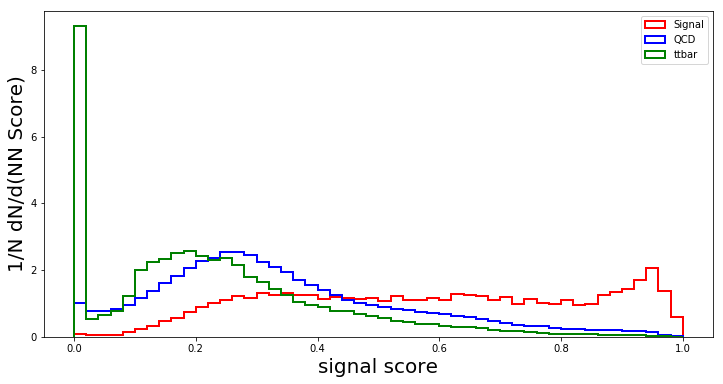

In [39]:
pred_loaded = loaded_model.predict(X_run_forload)

loaded_model_Data = pandas.DataFrame(X_run_forload)
loaded_model_Data['sig_score'] = pandas.Series(pred_loaded[:,0], index=loaded_model_Data.index)
loaded_model_Data['qcd_score'] = pandas.Series(pred_loaded[:,1], index=loaded_model_Data.index)
loaded_model_Data['top_score'] = pandas.Series(pred_loaded[:,2], index=loaded_model_Data.index)
loaded_model_Data['weight'] = pandas.Series(evtWeightsRun, index=loaded_model_Data.index)
loaded_model_Data['process'] = pandas.Series(yTypeRun, index=loaded_model_Data.index)

hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(loaded_model_Data[loaded_model_Data.process == 0]['sig_score'], color=["r"], weights=loaded_model_Data[loaded_model_Data.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(loaded_model_Data[loaded_model_Data.process == 1]['sig_score'], color=["b"], weights=loaded_model_Data[loaded_model_Data.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(loaded_model_Data[loaded_model_Data.process == 2]['sig_score'], color=["g"], weights=loaded_model_Data[loaded_model_Data.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)

In [40]:
pred_sig_only = model.predict(allXdata_scaled)

Text(0,0.5,'1/N dN/d(NN Score)')

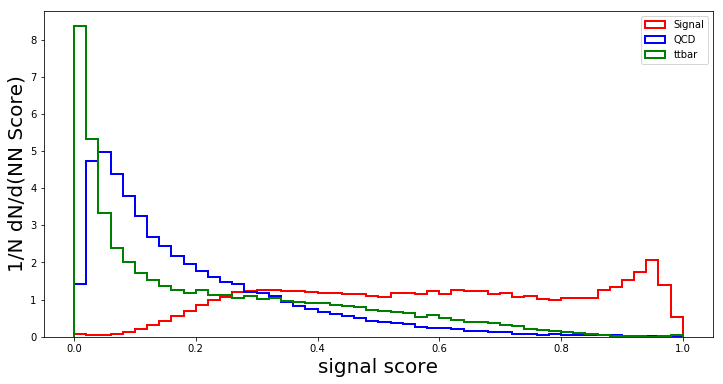

In [41]:
sig_only_Data = pandas.DataFrame(allXdata_scaled)
sig_only_Data['sig_score'] = pandas.Series(pred_sig_only[:,0], index=sig_only_Data.index)
sig_only_Data['qcd_score'] = pandas.Series(pred_sig_only[:,1], index=sig_only_Data.index)
sig_only_Data['top_score'] = pandas.Series(pred_sig_only[:,2], index=sig_only_Data.index)

hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(sig_only_Data['sig_score'], color=["r"], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(sig_only_Data['qcd_score'], color=["b"], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(sig_only_Data['top_score'], color=["g"], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)

/cvmfs/sft.cern.ch/lcg/views/LCG_94python3/x86_64-slc6-gcc8-opt/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0,0.5,'1/N dN/d(NN Score)')

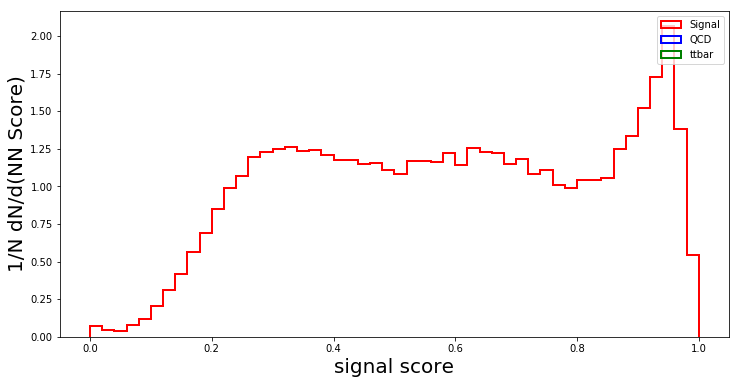

In [42]:
sig_only_Data['weight'] = pandas.Series(sig_only_mc_sf, index=sig_only_Data.index)
sig_only_Data['process'] = pandas.Series(sig_only_target, index=sig_only_Data.index)

hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(sig_only_Data[sig_only_Data.process == 0]['sig_score'], color=["r"], weights=sig_only_Data[sig_only_Data.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(sig_only_Data[sig_only_Data.process == 1]['sig_score'], color=["b"], weights=sig_only_Data[sig_only_Data.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(sig_only_Data[sig_only_Data.process == 2]['sig_score'], color=["g"], weights=sig_only_Data[sig_only_Data.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)